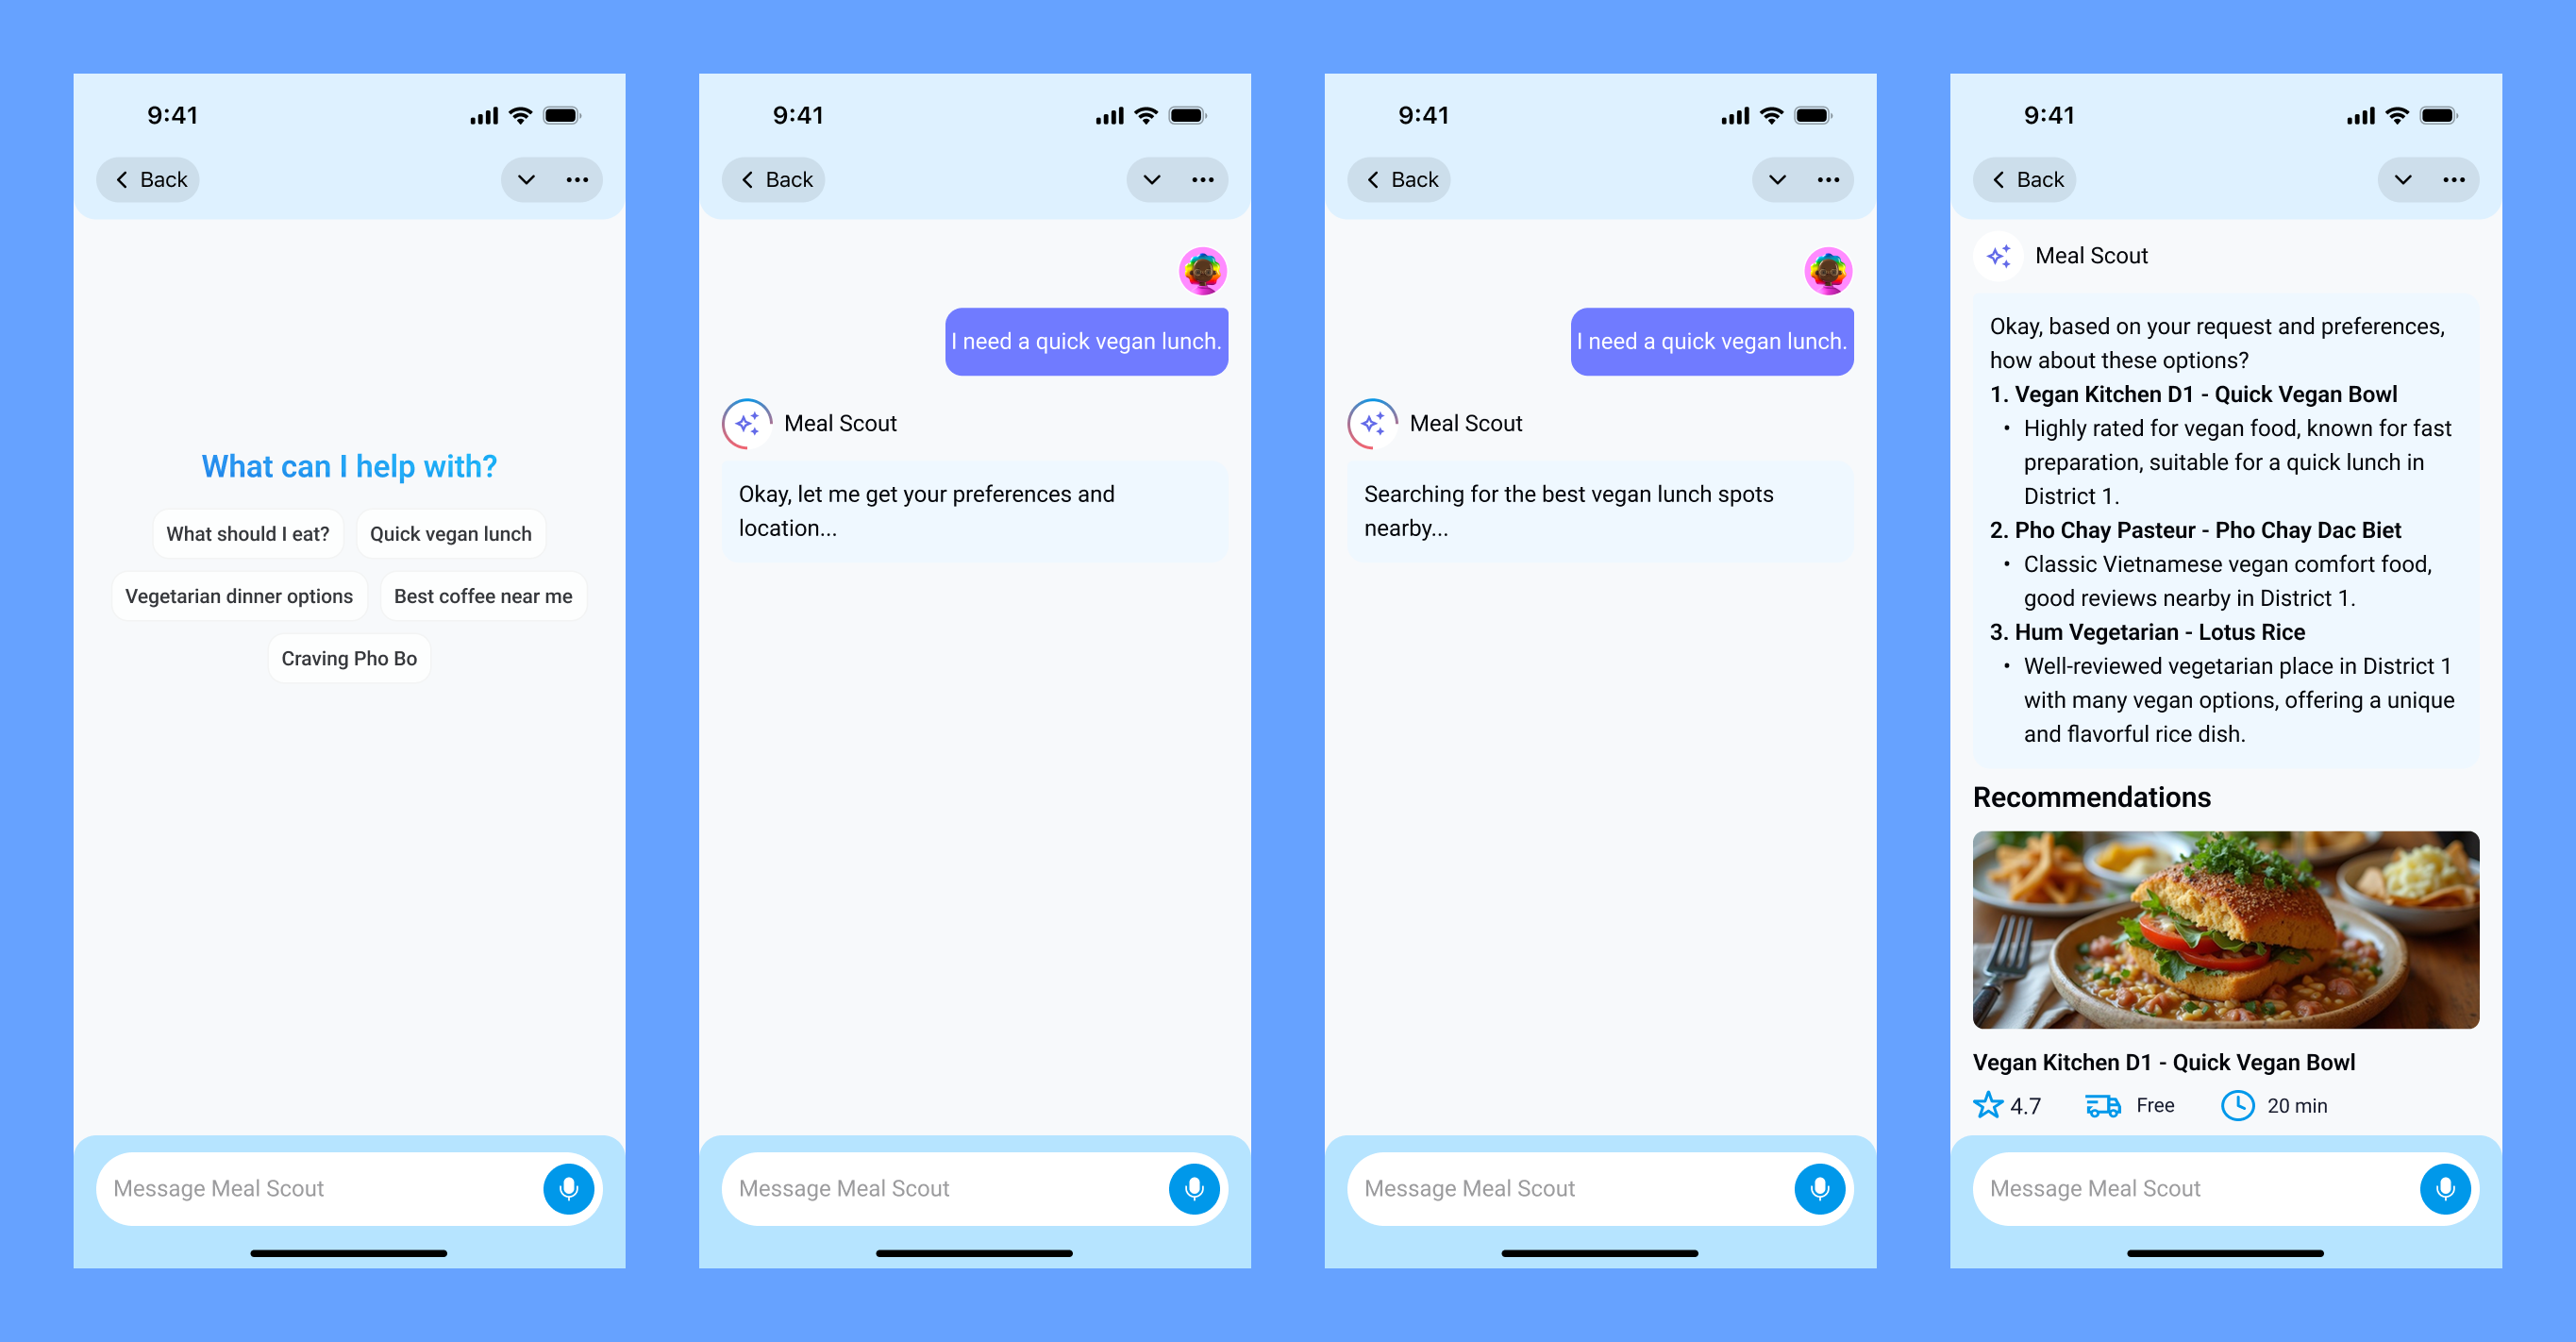

# Case Study: Personalized Meal Recommender Agent

## Introduction

This notebook demonstrates building a **Personalized Meal Recommender Agent** for a food delivery platform.

**Problem: The "What Should I Eat?" Dilemma**

* **Overchoice:** Users face numerous restaurants and dishes, making decisions difficult.
* **Personal Needs:** Finding options matching specific dietary restrictions (vegan, allergies), cuisine preferences, budget, and current context (quick lunch, fancy dinner) is time-consuming.
* **Generic Results:** Standard filters often lack nuanced personalization based on past behavior or implicit user needs.

**Solution: AI-Powered Personalized Recommendations**

This project builds an agent that understands user queries in context, retrieves relevant user-specific information, searches for suitable options, and provides tailored recommendations. It leverages:

* **Intelligent Recommendation Engine:** Leverages AI to understand user preferences and context for personalized suggestions.
* **Multi-Step Decision Process:** Analyzes user profile, dietary needs, and past orders to find the best matches.
* **Data Integration Layer:** Connects user information, restaurant options, and contextual factors to make informed recommendations.

**Project Focus & Limitations**

This demonstration will showcase:

* An agent following a refined workflow using custom data-fetching tools.
* LangGraph coordinating the sequence of tool calls.
* Generating personalized recommendations based on simulated user data and context.

This demonstration will **not** cover:
* Integration with real user databases or restaurant APIs.
* Real-time order placement.
* Complex preference learning or feedback loops.

**Key Components:**

* **LLM:** Gemini 2.0 Flash. The brain of the agent.
* **Tools:** Custom tools (`get_user_info`, `get_user_location`, `get_order_history`, `find_restaurants`, `recommendation_formatter`).
* **LangChain, LangGraph Framework:** Core frameworks for building the agent.
* **Prompt Engineering:** A system prompt guiding the agent through the specific workflow.


## Agent Workflow

The agent follows this workflow:

1.  **Extract Parameters:** Identify context/occasion (e.g., "quick lunch," "fancy dinner," "comfort food") from the user's input query.
2.  **Get User Info:** Use the `get_user_info` tool to retrieve persistent user preferences (cuisine likes/dislikes, dietary restrictions, spice level) from a database.
3.  **Get User Location:** Use the `get_user_location` tool to determine the current delivery location.
4.  **Get Order History:** Use the `get_order_history` tool to fetch a summary of recent orders for context.
5.  **Find Restaurants:** Use the `find_restaurants` tool, providing it with the extracted parameters, user info, location, and order history, to search/filter and identify suitable restaurants and/or specific dishes.
6.  **Format Recommendations:** Use the `recommendation_formatter` tool to assemble the findings into a ranked, user-friendly list with justifications.
7.  **Return Recommendations:** Present the personalized recommendations to the user.

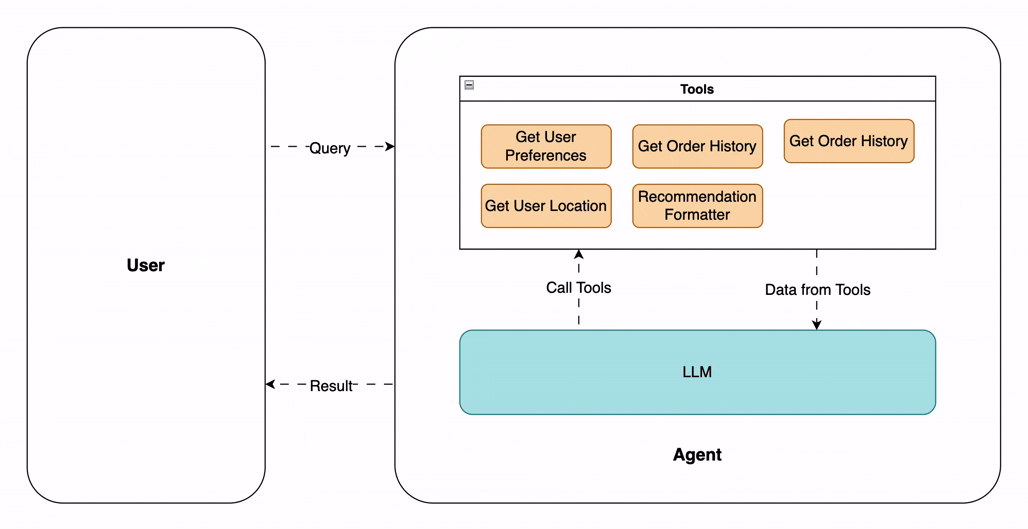

## Implementation Steps

### Setting Up the Environment

In [1]:
# Load the environment variables
import os
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
# Set up the LLM
from langchain_google_genai import ChatGoogleGenerativeAI

GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY")
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=GEMINI_API_KEY)

### Configuring the Tools
We'll define our custom tools. These tools still return mock data, even though we're using a real LLM. The LLM will call these tools, but receive the predefined mock responses.

In [ ]:
from typing import List, Dict, TypedDict
from langchain_core.tools import tool
import random

# Define Schemas
class UserInfo(TypedDict):
    """Structure for user profile information."""
    preferences: List[str]
    dietary: List[str]
    allergies: List[str]
    spice: str # e.g., "none", "mild", "medium", "spicy"

class SuggestionItem(TypedDict):
    """Structure for a single restaurant/dish suggestion."""
    name: str
    dish: str
    location: str
    reason: str

# Mock User Database
mock_user_data: Dict[str, UserInfo] = {
    "user_123": {
        "preferences": ["Vietnamese", "Thai", "Italian"],
        "dietary": ["vegan"],
        "allergies": ["none"],
        "spice": "medium"
    },
    "user_456": {
        "preferences": ["Korean", "Japanese", "Vietnamese"],
        "dietary": [], # No specific dietary restrictions
        "allergies": ["shellfish"], # Allergy example
        "spice": "spicy"
    },
    "user_789": { # User focused on healthy options
        "preferences": ["Mediterranean", "Salads", "Smoothies"],
        "dietary": ["low-carb"],
        "allergies": ["gluten"],
        "spice": "mild"
    }
}

# Mock Order History
mock_order_history: Dict[str, List[Dict[str, str]]] = {
    "user_123": [
        {"restaurant": "Hum Vegetarian", "dish": "Lotus Rice", "date": "2025-03-26"},
        {"restaurant": "Vegan Kitchen D1", "dish": "Vegan Pho", "date": "2025-03-24"},
        {"restaurant": "Pizza 4P's", "dish": "Vegan Margherita", "date": "2025-03-22"},
        {"restaurant": "Spice Bistro", "dish": "Tofu Curry", "date": "2025-03-20"},
    ],
    "user_456": [
        {"restaurant": "GoGi House", "dish": "Spicy Pork Bulgogi", "date": "2025-03-25"},
        {"restaurant": "Sushi Hokkaido Sachi", "dish": "Salmon Sashimi Set", "date": "2025-03-23"},
        {"restaurant": "Pho Le", "dish": "Pho Tai", "date": "2025-03-21"},
    ],
    "user_789": [
        {"restaurant": "Poke Saigon", "dish": "Custom Salmon Bowl (no rice)", "date": "2025-03-26"},
        {"restaurant": "L'Usine", "dish": "Quinoa Salad (no croutons)", "date": "2025-03-24"},
        {"restaurant": "Juice Box", "dish": "Green Detox Smoothie", "date": "2025-03-22"},
    ]
}

@tool
def get_user_info(user_id: str) -> UserInfo: # Require user_id
    """Retrieves the user's preferences, dietary restrictions, and allergies from the database for the given user_id."""
    print(f"--- Tool: get_user_info called for user {user_id} ---")
    default_info: UserInfo = {"preferences": [], "dietary": [], "allergies": [], "spice": "none"}
    return mock_user_data.get(user_id, default_info)

@tool
def get_user_location(user_id: str) -> str: # Require user_id
    """Gets the user's current location, likely from device context or profile for the given user_id."""
    print(f"--- Tool: get_user_location called for user {user_id} ---")
    # Add some location variety based on user
    if user_id == "user_456":
        return "District 7, Ho Chi Minh City"
    elif user_id == "user_789":
        return "District 2, Ho Chi Minh City"
    else: # Default to D1 for user_123 or unknown
        return "District 1, Ho Chi Minh City"

@tool
def get_order_history(user_id: str, num_orders: int = 3) -> List[str]: # Require user_id
    """Retrieves the user's most recent order history summary (dish and restaurant) for the given user_id."""
    print(f"--- Tool: get_order_history called for user {user_id}, num_orders={num_orders} ---")
    return [f"{order['dish']} from {order['restaurant']}" for order in mock_order_history.get(user_id, [])[:num_orders]]

@tool
def find_restaurants(context: str, user_info: UserInfo, location: str, order_history: List[str]) -> List[SuggestionItem]:
    """
    Finds suitable restaurants based on user query context, preferences, location, and history.
    Args:
        context (str): The user's immediate need (e.g., 'quick lunch', 'fancy dinner').
        user_info (UserInfo): Dictionary containing 'preferences', 'dietary', 'allergies', 'spice'.
        location (str): The user's delivery location.
        order_history (List[str]): List of recent dishes/restaurants ordered summary strings.
    Returns:
        List[SuggestionItem]: A list of dictionaries, each containing suggestion details.
    """
    print(f"--- Tool: find_restaurants called ---")
    print(f"Context Received: {context}")
    # Access UserInfo dictionary items safely
    print(f"User Info Received: preferences={user_info.get('preferences')}, dietary={user_info.get('dietary')}, spice={user_info.get('spice')}")
    print(f"Location Received: {location}")
    print(f"Order History Received: {order_history}")

    # Mock Search Logic (ensure returned dictionaries match SuggestionItem)
    suggestions: List[SuggestionItem] = [] # Ensure list contains SuggestionItem dictionaries
    user_dietary = [d.lower() for d in user_info.get("dietary", [])]
    user_prefs = [p.lower() for p in user_info.get("preferences", [])]
    context_lower = context.lower()

    if "vegan" in user_dietary and "district 1" in location.lower() and ("quick" in context_lower and "lunch" in context_lower):
        suggestions.append({
            'name': 'Vegan Kitchen D1',
            'dish': 'Quick Vegan Bowl',
            "location": "District 1, Ho Chi Minh City",
            'reason': 'Highly rated for vegan food, known for fast preparation, suitable for a quick lunch in District 1.'
        })
        if not any("Pho Chay" in item for item in order_history):
             suggestions.append({
                'name': 'Pho Chay Pasteur',
                'dish': 'Pho Chay Dac Biet',
                "location": "District 1, Ho Chi Minh City",
                'reason': 'Classic Vietnamese vegan comfort food, good reviews nearby in District 1.'
             })
        suggestions.append({
             'name': 'Hum Vegetarian',
             'dish': 'Lotus Rice',
             'location': "District 1, Ho Chi Minh City",  # Added missing location field
             'reason': 'Well-reviewed vegetarian place in District 1 with many vegan options, offering a unique and flavorful rice dish.'
        })

    elif "comfort food" in context_lower:
         if "vietnamese" in user_prefs:
             suggestions.append({
                 'name': 'Ngon Restaurant',
                 'dish': 'Classic Chicken Pho (Pho Ga)',
                 "location": "District 1, Ho Chi Minh City",
                 'reason': 'Highly rated for traditional Vietnamese comfort food in your area.'
             })
         if "italian" in user_prefs:
             suggestions.append({
                 'name': 'Pizza 4P\'s',
                 'dish': 'Margherita Pizza',
                 "location": "District 1, Ho Chi Minh City",
                 'reason': 'Popular choice, often considered comforting, reliable quality.'
             })
         if not suggestions:
             suggestions.append({ 
                 'name': 'Local Soup Place', 
                 'dish': 'Hearty Vegetable Soup', 
                 'location': location,
                 'reason': 'A warm soup is often comforting.'
             })

    print(f"--- Tool: find_restaurants returning {len(suggestions)} suggestions ---")
    # Ensure only valid SuggestionItem dictionaries are returned
    valid_suggestions = [s for s in suggestions[:3] if all(k in s for k in SuggestionItem.__annotations__.keys())]
    return valid_suggestions

@tool
def recommendation_formatter(suggestions: List[SuggestionItem]) -> str:
    """Formats the list of restaurant/dish suggestions into a readable string for the user."""
    print(f"--- Tool: recommendation_formatter called with {len(suggestions)} suggestions ---")
    if not suggestions:
        return "Sorry, I couldn't find any specific recommendations matching all your criteria right now."

    output = "Okay, based on your request and preferences, how about these options?\n\n"
    for i, sugg in enumerate(suggestions):
        name = sugg['name']
        dish = sugg['dish']
        reason = sugg['reason']
        output += f"{i+1}. **{name} - {dish}**\n"
        output += f"   *Why?* {reason}\n\n"
    return output.strip()

# List of all tools for the agent
tools = [get_user_info, get_user_location, get_order_history, find_restaurants, recommendation_formatter]

### Configuring the Agent
Now we set up the agent components, crucially binding the tools to the actual LLM instance.

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import MessagesState, START, END
from langgraph.prebuilt import ToolNode

# Bind the tools to the LLM. This allows the LLM to format its output correctly for tool calling.
model_with_tools = llm.bind_tools(tools)

# Define the state for the graph
# MessagesState manages the list of messages: HumanMessage, AIMessage, ToolMessage
# state = {"messages": [HumanMessage(...), AIMessage(tool_calls=[...]), ToolMessage(...), ...]}

# Define the function that determines whether to continue or end the process
def should_continue(state: MessagesState) -> str:
    """Determines the next step: call tools or end."""
    last_message = state["messages"][-1]
    # If the LLM made tool calls, route to the tool node
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("--- Decision: Route to tools ---")
        return "tools"
    # Otherwise, end the conversation
    print("--- Decision: End ---")
    return END

# Define the function that calls the LLM (Revised for user_id in prompt)
def call_model(state: MessagesState):
    """Invokes the LLM with the current state messages."""
    print("--- Calling LLM ---")
    messages = state["messages"]

    # Determine user_id - get from thread_id mapping or config if available
    # For simplicity in this example, let's map thread_id to user_id
    thread_id = state.get("config", {}).get("configurable", {}).get("thread_id", "unknown_thread")
    if thread_id == "thread_1":
        current_user_id = "user_123"
    elif thread_id == "thread_2":
        current_user_id = "user_456"
    elif thread_id == "thread_3":
         current_user_id = "user_789"
    else:
        current_user_id = "user_123" # Default fallback

    # System Prompt including the user_id
    system_prompt = f"""You are a helpful food recommendation assistant for a delivery platform in Ho Chi Minh City. Your goal is to provide personalized meal suggestions for the current user (user_id: {current_user_id}).

    Follow these steps *strictly*:
    1.  Analyze the user's request to understand their immediate context (e.g., 'quick lunch', 'dinner', 'craving comfort food', specific cuisine).
    2.  Call the `get_user_info` tool, passing the correct `user_id` ('{current_user_id}').
    3.  Call the `get_user_location` tool, passing the correct `user_id` ('{current_user_id}').
    4.  Call the `get_order_history` tool, passing the correct `user_id` ('{current_user_id}') and requesting about 3 recent orders.
    5.  **ONLY AFTER** gathering user info, location, and history (wait for ToolMessages with results), call the `find_restaurants` tool. Provide it *exactly* with:
        * 'context': The context extracted in step 1.
        * 'user_info': The dictionary received from `get_user_info`.
        * 'location': The string received from `get_user_location`.
        * 'order_history': The list received from `get_order_history`.
    6.  **AFTER** receiving results from `find_restaurants` (wait for the ToolMessage), call the `recommendation_formatter` tool with the suggestions list received.
    7.  **AFTER** receiving the formatted string from `recommendation_formatter`, present *exactly that string* to the user as your final response for this turn. Do not add extra conversational text unless the formatter returned an error message.

    *Do not* suggest restaurants directly yourself. Rely *entirely* on the `find_restaurants` tool for searching and the `recommendation_formatter` tool for the final output format.
    *Do not* ask the user for information that the tools can provide. Call the tools directly using the user_id '{current_user_id}'.
    If the user query is very vague (e.g., "I'm hungry"), you can ask for clarification, but if it mentions time (lunch/dinner), cuisine, or type (quick/fancy), proceed with the tool workflow.
    """

    # Prepend/update system prompt
    if not messages or not isinstance(messages[0], SystemMessage):
        messages_with_system = [SystemMessage(content=system_prompt)] + messages
    else:
        messages_with_system = [SystemMessage(content=system_prompt)] + messages[1:]

    # Invoke the LLM
    response = model_with_tools.invoke(messages_with_system)
    print(f"--- LLM Response (raw): {response} ---")

    return {"messages": [response]}

# Define the tool node that executes the called tools
# This node will receive AIMessage(tool_calls=...) and return ToolMessage(...)
tool_node = ToolNode(tools)

### Building the Graph
Assemble the nodes and edges into a state graph.

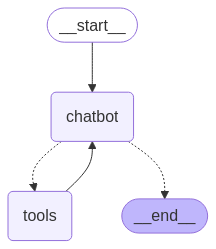

In [ ]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# Initialize the graph
workflow = StateGraph(MessagesState)

# Add the nodes
workflow.add_node("chatbot", call_model)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "chatbot")

# Add conditional edge: After LLM call, check if tools need to be called or if it should end
workflow.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "tools": "tools", # If tool calls are present, go to tool node
        END: END          # Otherwise, end the graph
    }
)

# Add edge: After tools are executed, return control to the LLM node
workflow.add_edge("tools", "chatbot")

# Set up memory to persist conversation state
memory = MemorySaver()

# Compile the graph into a runnable app
app = workflow.compile(checkpointer=memory)

# Visualize the graph (optional, requires graphviz)
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Graph visualization failed (is graphviz installed?): {e}")

### Testing the Agent
Let's define a function to interact with the agent and test it with sample queries.

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
import sys

# Define the agent runner function
def recommend_food(query: str, thread_id: str):
    """Runs the food recommendation agent for a given query and thread ID."""
    config = {"configurable": {"thread_id": thread_id}} # thread_id passed in config
    inputs = {"messages": [HumanMessage(content=query)]}

    print(f"\n--- User Query: {query} (Thread: {thread_id}) ---")

    final_response = None
    try:
        for event in app.stream(inputs, config, stream_mode="values"):
            last_message = event["messages"][-1]

            if isinstance(last_message, AIMessage):
                if last_message.tool_calls:
                     print(f"\n>>> Agent decided to call tools: {[tc['name'] for tc in last_message.tool_calls]}")
                if last_message.content:
                     print(f"\n>>> Agent Response:\n{last_message.content}")
                     final_response = last_message.content

            elif isinstance(last_message, ToolMessage):
                print(f"\n--- Tool Result ({last_message.name}) ---") # Don't print full content, can be long
                # print(f"Content Snippet: {str(last_message.content)[:200]}...") # Optional: Print snippet

    except Exception as e:
        print(f"\n--- ERROR during agent run: {e} ---")
        import traceback
        traceback.print_exc() # Print full traceback for debugging

    print("\n--- Agent Run Finished ---")
    return final_response

# --- Test Queries for Different Users ---
test_scenarios = [
    {"user_id_tag": "user_123", "thread_id": "thread_1", "query": "I need a quick vegan lunch."},
    {"user_id_tag": "user_456", "thread_id": "thread_2", "query": "Looking for some spicy Korean food for dinner."}, # Test user 456 (D7, spicy, Korean pref, shellfish allergy)
    {"user_id_tag": "user_789", "thread_id": "thread_3", "query": "Suggest a healthy, low-carb salad near D2."}, # Test user 789 (D2, healthy, low-carb, gluten allergy)
    {"user_id_tag": "user_123", "thread_id": "thread_1", "query": "Anything similar to the Lotus Rice I had?"}, # Test history context for user 123
    {"user_id_tag": "user_456", "thread_id": "thread_2", "query": "Find me some good Japanese options, but no shellfish!"}, # Test allergy handling for user 456
    {"user_id_tag": "user_123", "thread_id": "thread_1", "query": "I want Italian tonight, something fancy."}, # Test context + pref for user 123
]

In [18]:
# Run the tests
recommend_food(test_scenarios[0]["query"], test_scenarios[0]["thread_id"])


--- User Query: I need a quick vegan lunch. (Thread: thread_1) ---
--- Calling LLM ---
--- LLM Response (raw): content='' additional_kwargs={'function_call': {'name': 'get_user_info', 'arguments': '{"user_id": "user_123"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-69e84bce-fff0-4efa-954f-ff15e11f788b-0' tool_calls=[{'name': 'get_user_info', 'args': {'user_id': 'user_123'}, 'id': '53e40be1-9f0f-49cb-ab47-9d93ade99a57', 'type': 'tool_call'}] usage_metadata={'input_tokens': 816, 'output_tokens': 13, 'total_tokens': 829, 'input_token_details': {'cache_read': 0}} ---
--- Decision: Route to tools ---

>>> Agent decided to call tools: ['get_user_info']
--- Tool: get_user_info called for user user_123 ---

--- Tool Result (get_user_info) ---
--- Calling LLM ---
--- LLM Response (raw): content='' additional_kwargs={'function_call': {'name': 'get_user_location', 'arguments': '{"user_id": "user_123"}'

'Okay, based on your request and preferences, how about these options?\n\n1. **Vegan Kitchen D1 - Quick Vegan Bowl**\n   *Why?* Highly rated for vegan food, known for fast preparation, suitable for a quick lunch in District 1.\n\n2. **Pho Chay Pasteur - Pho Chay Dac Biet**\n   *Why?* Classic Vietnamese vegan comfort food, good reviews nearby in District 1.\n\n3. **Hum Vegetarian - Lotus Rice**\n   *Why?* Well-reviewed vegetarian place in District 1 with many vegan options, offering a unique and flavorful rice dish.'

## Conclusion

This notebook successfully demonstrated a **Personalized Meal Recommender Agent**, implementing a workflow with custom tools.

**Key Observations from Testing:**

1.  **Successful Workflow Execution:** The agent consistently followed the defined 7-step process across various test queries. As seen in the "quick vegan lunch" test for `user_123`, it correctly identified the context, fetched user-specific mock data (preferences, location, history), utilized the `find_restaurants` tool with this combined information, and formatted the output appropriately using `recommendation_formatter`.
2.  **Effective Tool Orchestration:** LangGraph, guided by the detailed system prompt, effectively managed the sequence of tool calls, ensuring data dependencies were met (e.g., fetching user info before finding restaurants).
3.  **Personalization with Mock Data:** The use of custom tools returning mock, user-specific data allowed the agent to generate tailored suggestions. For instance, it leveraged the `vegan` preference and `District 1` location for `user_123`.
4.  **Structured Output:** The final recommendations presented to the user were well-formatted and included justifications, making them easy to understand.

This implementation showcases how a structured agent workflow combined with specific tools (even when simulated) can create powerful, personalized user experiences within a complex domain like food delivery.

**Next Steps:**

* **Real Integration:** Replace mock tools with connections to actual user databases, restaurant APIs (for menus, hours, ratings, potentially real-time availability), and location services.
* **Sophisticated Recommendation Logic:** Enhance the `find_restaurants` tool with more advanced techniques like:
    * Embedding-based search for semantic matching (e.g., matching "comfort food" to relevant dishes).
    * Collaborative filtering (suggesting items liked by similar users).
    * Real-time data (trending items, promotions).
    * More nuanced handling of order history (avoiding similar cuisines, suggesting complementary items).
* **Error Handling & Fallbacks:** Implement robust error handling within tools and the graph workflow for API failures or unexpected data.
* **Feedback Loop:** Incorporate user feedback on suggestions to continuously improve the personalization model.